In [1]:
import sys
sys.path.insert(0, "../../../pymc")

import pymc as pm
import numpy as np

import aesara.tensor as at
import aesara

from aesara.tensor import TensorVariable

from pymc.distributions.logprob import logp

from aeppl.abstract import MeasurableVariable
from aesara.compile.builders import OpFromGraph

Data and `rng`

In [2]:
rng = np.random.RandomState(seed=34)
y_obs = np.concatenate(
    (
        rng.normal(loc=10, scale=2., size=[20,]),
        rng.normal(loc=-10, scale=2., size=[20,]),
    )
)

In [3]:
def mixture_rv_op(weights, components):
    single_component = (len(components) == 1)
    mix_indexes_rng = aesara.shared(np.random.default_rng())

    # Extract support and replication ndims from components and weights
    component_ndim_supp = components[0].owner.op.ndim_supp
    component_ndim_reps = components[0].ndim - component_ndim_supp
    weights_ndim_reps = max(0, weights.ndim - component_ndim_reps - 1)

    # Broadcast weights to (*replication dimensions, stack dimension),
    # ignoring support dimensions
    if single_component:
        weights_broadcast_shape = at.concatenate(
            [
            weights.shape[:weights_ndim_reps],
            components[0].shape[:component_ndim_reps],
        ],
        axis=-1,
        )
    else:
        weights_broadcast_shape = at.concatenate(
            [
                weights.shape[:weights_ndim_reps],
                components[0].shape[:component_ndim_reps],
                [len(components)],
            ],
            axis=-1,
        )

    weights_broadcasted = at.broadcast_to(weights, weights_broadcast_shape)

    # Draw mixture indexes
    mix_indexes = at.random.categorical(weights_broadcasted, rng=mix_indexes_rng)

    # Append (ndim_supp + stack) dimensions to the right of mix_indexes
    mix_indexes_padded = at.shape_padright(mix_indexes, component_ndim_supp + 1)

    # Append  missing dimensions (if any) to the left of stacked_components
    if single_component:
        mix_out = at.take_along_axis(components[0], mix_indexes_padded, axis=-1)
    else:
        stacked_components = at.stack(components, axis=-1)
        stacked_components_padded = at.shape_padleft(
            stacked_components,
            mix_indexes_padded.ndim - stacked_components.ndim,
        )

        # Index components and squeeze stack dimension
        mix_out = at.take_along_axis(stacked_components_padded, mix_indexes_padded, axis=-1)
    # There is a Aeasara bug in squeeze with negative axis
    # mix_out_ = at.squeeze(mix_out_, axis=-1)
    mix_out = at.squeeze(mix_out, axis=mix_out.ndim - 1)
    
    return mix_out

## Batched components

In [4]:
with pm.Model():
    weights = at.as_tensor_variable([0.5, 0.5])
    
    mu1 = pm.Normal("mu", mu=-10, sigma=1)
    mu2 = pm.Normal("mu2", mu=10, sigma=1)
    
    norm_dist_1 = pm.Normal.dist(mu=mu1, sigma=2)
    norm_dist_2 = pm.Normal.dist(mu=mu2, sigma=2)
    
    components = [norm_dist_1, norm_dist_2]
    
mixture_rv_op(weights, components).eval()

array(10.80347581)

## Single Batched Component

In [5]:
with pm.Model():
    mu = pm.Normal(name="mu", mu=0., sigma=5., shape=(2,))
    components = [pm.Normal.dist(mu=mu, sigma=3., shape=(2,))]
    
    weights = at.as_tensor_variable([0.5, 0.5])
    
mixture_rv_op(weights, components).eval()

array(7.08905302)

## Testing `pm.Mixture` API

In [6]:
with pm.Model() as single_batched_model:
    mu = pm.Normal(name="mu", mu=[-10, 10], sigma=3)
    
    weights = at.as_tensor_variable([0.5, 0.5])
    
    mix = pm.Mixture("mix", weights, pm.Normal.dist(mu=mu, sigma=3))
    
    trace = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, mix]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


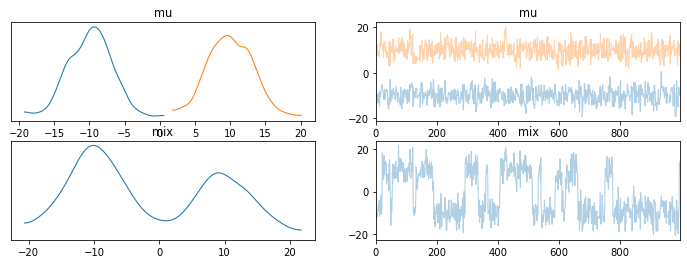

In [7]:
_ = pm.plot_trace(trace)

In [8]:
mean_ = np.broadcast_to(np.array([[0, 0], [1, 1], [2, 2]]), (5, 3, 2))

with pm.Model() as single_batched_mv_model:
    mu = pm.MvNormal(name="mu", mu=mean_, cov=np.eye(2)*0.1)
    
    weights = at.as_tensor_variable([0.2, 0.3, 0.5])
    
    components = pm.MvNormal.dist(
        mu=mu,
        cov=np.eye(2)*0.1,
    )
    
    mix = pm.Mixture("mix", weights, components)
    
mix.eval()

array([[1.96818322, 2.67394773],
       [0.64282497, 2.01068835],
       [0.45956538, 0.95877403],
       [1.54362747, 1.46854249],
       [2.53885427, 2.69696057]])

In [9]:
with single_batched_mv_model:
    trace = pm.sample(chains=1,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: Invalid dimension for value: 3